In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z', 1: 'z'}) -> QuantumCircuit:
    """For E91, we take state to be '00', '01', '10', '11' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(2)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[1] == '1':
        qc.x(1)
    
    # create the superposition
    qc.h(0)
    qc.cx(0,1)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('01',100).draw())

        ┌───┐     ┌────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├─░─┤M├───
        ├───┤┌─┴─┐├────────────────┤ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ Delay(100[ns]) ├─░──╫─┤M├
        └───┘└───┘└────────────────┘ ░  ║ └╥┘
meas: 2/════════════════════════════════╩══╩═
                                        0  1 


In [4]:
print(create_circuit('00',100,{0: 'z', 1: 'x'}).draw())

        ┌───┐     ┌────────────────┐      ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├──────░─┤M├───
        └───┘┌─┴─┐├────────────────┤┌───┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├┤ Delay(100[ns]) ├┤ H ├─░──╫─┤M├
             └───┘└────────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1 


In [5]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","sdg","id"])
        
        q2_len = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q2_gate_len)
        thermal_gate_2q = q2_len.tensor(q2_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_2q,"cx")
    
    return noise_model

In [6]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['sdg', 'h', 'measure', 'id', 'delay', 'x', 'cx']>

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['measure', 'delay']>

In [8]:
noise_params = {"T1":93400, "T2":116160} # ibmq_lima
q1_gate_len = 200 # couldn't find
q2_gate_len = 405.33 # ibmq_lima
measure_len = 5351.11 # ibmq_lima

In [9]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for E91 protocol"""
    """Channel: 1 => |00>+|11>, 2 => |01>+|10>"""
    
    if channel == '1':
        state = '00'
    elif channel == '2':
        state = '01'
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    
    success = 0
    
    if channel == '1':
        if '00' in counts.keys():
            success += counts['00']
        if '11' in counts.keys():
            success += counts['11']
    
    elif channel == '2':
        if '01' in counts.keys():
            success += counts['01']
        if '10' in counts.keys():
            success += counts['10']
            
    return float(success/shots)

In [10]:
run('1',1000,{"delay": True, "measure": False, "gate": False})

0.989

In [11]:
run('1',1000,{"delay": True, "measure": True, "gate": False})

0.946

In [12]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

0.935

In [19]:
import matplotlib.pyplot as plt

listofSuccess1=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess1.append(success)
    

In [20]:
from statistics import mean
a= listofSuccess1
print(*map(mean, zip(*a)))

1.0 0.9895 0.9802 0.97125 0.95885 0.94645 0.94045 0.9322 0.92415 0.91605 0.908 0.90035 0.8937 0.88865 0.8796 0.8727 0.8654499999999999 0.86385 0.8563 0.8523999999999999 0.8463499999999999 0.84 0.83175 0.8251999999999999 0.8241999999999999 0.8245 0.8223 0.8128 0.8047 0.8067 0.8046 0.7942 0.7887500000000001 0.7896000000000001 0.7886000000000001 0.7816000000000001 0.7782 0.7827000000000001 0.77385 0.77 0.7726500000000001 0.76945 0.7723 0.76685 0.7614 0.76565 0.7578 0.75735 0.7588 0.75805 0.7598 0.75535 0.7532 0.75225 0.7556 0.75085 0.7531 0.75435 0.7532 0.7521 0.7528 0.7519 0.75095 0.74865 0.7488 0.75045 0.74455 0.75005 0.75015 0.74825 0.7516 0.75115 0.74885 0.75035 0.74835 0.75065 0.7548 0.75095 0.7567 0.7573 0.7564 0.7532 0.7564 0.758 0.76175 0.75645 0.75595 0.7597 0.75575 0.7616 0.7604 0.7633 0.7649 0.7702 0.76265 0.7689 0.7688 0.7736500000000001 0.77025 0.7701 0.77515 0.78005 0.7752 0.7762 0.7816000000000001 0.78095 0.7787000000000001 0.7826500000000001 0.784 0.7783 0.7832 0.79015 0.7

In [24]:
# 20 Times Average 
b=[1.0,0.9895,0.9802,0.97125,0.95885,0.94645,0.94045,0.9322,0.92415,0.91605,0.908,0.90035,0.8937,0.88865,0.8796,0.8727,0.8654499999999999,0.86385,0.8563,0.8523999999999999,0.8463499999999999,0.84,0.83175,0.8251999999999999,0.8241999999999999,0.8245,0.8223,0.8128,0.8047,0.8067,0.8046,0.7942,0.7887500000000001,0.7896000000000001,0.7886000000000001,0.7816000000000001,0.7782,0.7827000000000001,0.77385,0.77,0.7726500000000001,0.76945,0.7723,0.76685,0.7614,0.76565,0.7578,0.75735,0.7588,0.75805,0.7598,0.75535,0.7532,0.75225,0.7556,0.75085,0.7531,0.75435,0.7532,0.7521,0.7528,0.7519,0.75095,0.74865,0.7488,0.75045,0.74455,0.75005,0.75015,0.74825,0.7516,0.75115,0.74885,0.75035,0.74835,0.75065,0.7548,0.75095,0.7567,0.7573,0.7564,0.7532,0.7564,0.758,0.76175,0.75645,0.75595,0.7597,0.75575,0.7616,0.7604,0.7633,0.7649,0.7702,0.76265,0.7689,0.7688,0.7736500000000001,0.77025,0.7701,0.77515,0.78005,0.7752,0.7762,0.7816000000000001,0.78095,0.7787000000000001,0.7826500000000001,0.784,0.7783,0.7832,0.79015,0.7889,0.79365,0.79605,0.7976500000000001,0.7922,0.794,0.7955,0.7991,0.7965,0.79905,0.8054,0.8006500000000001,0.80815,0.809,0.8102,0.8082,0.81015,0.81115,0.8168,0.81505,0.8149,0.8200999999999999,0.82495,0.8236,0.82485,0.8244499999999999,0.8239,0.8303499999999999,0.82305,0.83085,0.83165,0.82875,0.8282499999999999,0.8333499999999999,0.8286,0.8379,0.8372999999999999,0.8406,0.83855,0.83895,0.84195,0.83775,0.8443999999999999,0.84605,0.8503999999999999,0.8496,0.8503999999999999,0.8525,0.8493999999999999,0.8526,0.85515,0.8556,0.8563999999999999,0.86185,0.8589,0.86325,0.8603,0.86365,0.8654999999999999,0.86675,0.86875,0.8691,0.8687,0.8713,0.8688,0.87305,0.87415,0.87605,0.88065,0.87845,0.8766,0.88095,0.87925,0.8821,0.8809,0.8848,0.8811,0.8857,0.88745,0.88715,0.88745,0.8895,0.89035,0.89605,0.8916000000000001,0.8935,0.8909,0.89475,0.89525,0.9001,0.8976000000000001,0.899,0.8957,0.89895,0.9006000000000001,0.90115,0.9044,0.9018,0.9092,0.90395,0.9094,0.90495,0.90825,0.9086500000000001,0.9108,0.9136000000000001,0.9116000000000001,0.9146000000000001,0.9164,0.91485,0.91795,0.91605,0.9186000000000001,0.9188000000000001,0.92035,0.91605,0.9191,0.9208000000000001,0.92095,0.9235,0.9225,0.9234,0.92705,0.9252,0.92605,0.92915,0.92715,0.9299000000000001,0.9285,0.9317,0.9324,0.9337,0.9337,0.93405,0.93645,0.9369999999999999,0.933,0.9341,0.93565,0.93635,0.9363,0.9357,0.9403,0.9410499999999999,0.9399,0.9398,0.94145,0.93995,0.9420499999999999,0.944,0.94505,0.94645,0.9462999999999999,0.945,0.9462999999999999,0.9471499999999999,0.946,0.94465,0.9467,0.9497,0.94775,0.94985,0.95255,0.94965,0.9521999999999999,0.95085,0.9521499999999999,0.9525,0.9538,0.9502499999999999,0.9543999999999999,0.952,0.9538,0.9538,0.9534499999999999,0.9584499999999999,0.9545,0.95655,0.95785,0.9587,0.9588,0.95965,0.9591999999999999,0.9613999999999999,0.9576,0.96215,0.96105,0.9604499999999999,0.9607,0.96295,0.96105,0.9622999999999999,0.9628,0.9641,0.9637,0.96455,0.96515,0.96475,0.9643999999999999,0.9639,0.9627,0.9663499999999999,0.9673499999999999,0.9692999999999999,0.96665,0.9686,0.9673999999999999,0.9696,0.9672,0.9676,0.9703499999999999,0.9723499999999999,0.9713499999999999,0.9715,0.97025,0.97185,0.97155,0.9729,0.9722,0.9702999999999999,0.97155,0.9733499999999999,0.97375,0.9733999999999999,0.97185,0.97505,0.9733499999999999,0.97455,0.9756,0.97325,0.97585,0.9753,0.97505,0.97565,0.977,0.9769,0.9753499999999999,0.97825,0.9768,0.9759,0.97675,0.9784999999999999,0.9783999999999999,0.97875,0.9773499999999999,0.979,0.9784999999999999,0.9778,0.9795,0.9787,0.98055,0.97965,0.9807,0.9813999999999999,0.9797,0.98055,0.98105,0.98225,0.9803,0.982,0.98065,0.9815,0.98275,0.9826,0.9813,0.9824499999999999,0.9824499999999999,0.98325,0.9829,0.9833,0.9838,0.98395,0.9839,0.98435,0.98395,0.9854499999999999,0.98265,0.9841,0.9864999999999999,0.9854499999999999,0.98625,0.98475,0.9837,0.9849,0.98515,0.9855,0.9852,0.98595,0.98575,0.98655,0.987,0.9879,0.9862,0.98735,0.98795,0.98825,0.98935,0.9873,0.9867,0.98805,0.98705,0.98965,0.98815,0.98905,0.9883,0.9901,0.98775,0.9892,0.9892,0.9888,0.9898,0.98875,0.98815,0.9896,0.9896,0.98895,0.9904499999999999,0.98915,0.99025,0.99005,0.9902,0.99035,0.99,0.9909,0.98905,0.99025,0.99135,0.99105,0.9912,0.9924,0.9926,0.99115,0.9904999999999999,0.9908,0.99125,0.9907,0.99155,0.9916,0.9913,0.99315,0.99225,0.9927,0.9914499999999999,0.9931,0.9915,0.9924999999999999,0.99225,0.9931,0.9931,0.9915,0.99315,0.9932,0.99485,0.9934499999999999,0.99305,0.993,0.99365,0.9939,0.99435,0.9938,0.9924999999999999,0.99455,0.99275,0.99375,0.9939,0.9932,0.99425,0.9939,0.99405,0.99365,0.9937,0.99315,0.99375,0.9929,0.9932,0.99465,0.99515,0.99415,0.9955,0.9944999999999999,0.9949,0.995,0.99405,0.9944,0.99655,0.9955,0.9944,0.9944999999999999,0.99555,0.9959,0.99555,0.99565,0.9962,0.9954,0.9957,0.995,0.996,0.9959,0.99515,0.99715,0.99535,0.99605,0.99635,0.99575,0.9958,0.996,0.99585,0.99675,0.99675,0.996,0.99585,0.9968,0.9961,0.9964,0.99665,0.99615,0.9962,0.9967,0.99685,0.99685,0.9967,0.99625,0.9968,0.9969,0.9978,0.99665,0.9972,0.9973,0.9969,0.997,0.99635,0.99675,0.99695,0.9972,0.9968,0.99735,0.99735,0.99765,0.99715,0.9969,0.9976,0.9979,0.99785,0.99705,0.99735,0.9977,0.9979,0.9981,0.99795,0.998,0.9975,0.9979,0.9968,0.9974,0.99745,0.9974,0.9978,0.9977,0.99745,0.9975,0.99795,0.99795,0.9978,0.99765,0.99825,0.9978,0.9978,0.99845,0.99755,0.9984999999999999,0.99845,0.99765,0.9981,0.99775,0.9978,0.998,0.9984,0.99775,0.99745,0.9983,0.99855,0.99875,0.9981,0.9984999999999999,0.99875,0.99815,0.99825,0.9983,0.99845,0.99875,0.9984999999999999,0.9983,0.99865,0.99855,0.9983,0.99835,0.9986,0.99835,0.9987,0.99865,0.99845,0.99875,0.99885,0.9987,0.99865,0.99875,0.99885,0.9977,0.99875,0.99885,0.9987,0.9986,0.99875,0.9989,0.99835,0.9989,0.99905,0.9988,0.9982,0.99875,0.99905,0.99865,0.9984999999999999,0.99895,0.9992,0.9989,0.99895,0.99875,0.99905,0.99875,0.99925,0.99905,0.99885,0.9992,0.9993,0.9988,0.99875,0.9993,0.9989,0.99905,0.99895,0.99895,0.99905,0.9991,0.99915,0.9995,0.99905,0.9995,0.9992,0.99955,0.99905,0.99945,0.9991,0.99935,0.9994,0.99915,0.9992,0.99885,0.9989,0.99895,0.9995,0.99915,0.99935,0.999,0.9993,0.9994,0.9991,0.99935,0.99945,0.99955,0.9994,0.99905,0.99925,0.99955,0.9992,0.99935,0.99955,0.99935,0.99935,0.99945,0.99945,0.9995,0.99935,0.99915,0.9996,0.99965,0.9994,0.99955,0.9997,0.99915,0.99945,0.99965,0.9993,0.9994,0.99975,0.9995,0.9994,0.99955,0.99955,0.99925,0.9994,0.99915,0.99935,0.99965,0.9995,0.99965,0.99945,0.9994,0.99975,0.99975,0.99925,0.99965,0.99945,0.99935,0.99975,0.9996,0.9996,0.9996,0.9995,0.9996,0.99975,0.9997,0.9996,0.9999,0.99965,0.99965,0.9997,0.9997,0.99935,0.99965,0.9998,0.99955,0.9997,0.9994,0.99985,0.99975,0.99955,0.99945,0.9996,0.9992,0.99965,0.99965,0.99985,0.99975,1.0,0.9998,0.99995,0.99975,0.99955,0.99975,0.9998,0.9998,0.99965,0.9995,0.99965,0.99965,0.99985,0.99985,0.99985,0.99975,0.9998,0.99975,0.9998,0.99975,0.99975,0.99985,0.9998,0.9997,0.9998,0.99985,0.99985,0.9997,0.99985,0.9998,0.9997,0.99985,0.99985,0.99985,0.99975,0.99985,0.99975,0.99955,0.99985,0.9998,0.99985,0.99985,0.99985,0.9998,0.99975,0.9998,0.99985,0.99995,0.99995,0.9998,0.9999,0.99975,0.99975,0.99975,0.9997,0.9998,0.99995,0.9998,0.99985,0.9999,0.9999,0.9996,0.9999,0.9999,0.99985,0.99995,0.99975,0.9997,0.99995,0.9998,0.9998,0.9998,0.99995,0.9999,0.99985,0.9998,0.9998,0.9999,0.99985,0.99995,0.99985,0.9999,0.99995,0.99995,0.99975,0.9999,0.99995,0.9998,1.0,0.9999,1.0,0.9999,0.9999,0.99985,0.99995,0.9998,0.99985,0.9997,0.9998,0.9999,0.99995,0.99995,0.99985,0.99995,0.99995,0.99995,0.99985,0.99985,0.99975,0.99985,0.9999,0.9999,0.99995,0.99995,0.99995,0.99985,1.0,0.99975,0.99995,1.0,0.99995,0.9999,0.99995,0.99995,0.99995,0.99985,0.9999,0.99995,0.99995,0.99995,0.9999,1.0,0.99975,0.99995,0.99995,1.0,0.99995,0.9999,1.0,1.0,0.99995,0.9999,1.0,0.9999,0.9999,1.0,0.99985,0.9999,1.0,0.9999,0.99995,1.0,0.99995,1.0,0.99995,0.99995,0.9999,0.9999,1.0,0.9999,0.99995,0.99995,1.0,1.0,0.99995,0.99995,0.9999,0.9999,0.9999,0.99995,0.99995,0.99995,0.9999,0.9999,0.99995,0.99995,0.99995,0.99995,0.9999,0.99985,0.9999,0.99995,0.99995,0.9998,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.9999,1.0,1.0,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,1.0,0.99995,1.0,1.0,0.9999,1.0,0.99995,1.0,0.99995,1.0,0.9999,0.9999,1.0,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,0.9999,1.0,0.9999,0.99995,1.0,1.0,1.0,1.0,0.9999,0.99995,0.99995,1.0,0.99995,1.0,0.9999,1.0,0.99995,1.0,1.0,1.0,1.0,1.0]

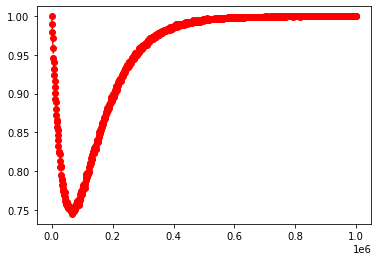

In [25]:
plt.plot(delay,b,'ro--')
plt.show()

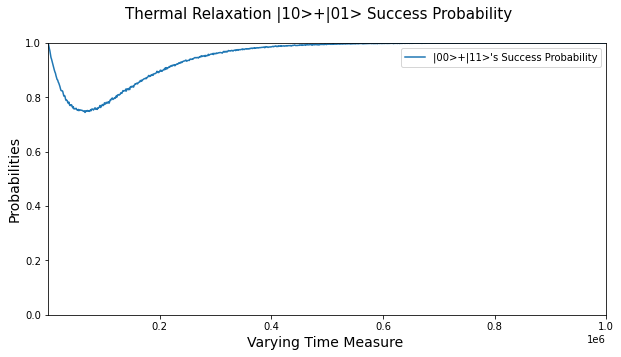

<Figure size 576x360 with 0 Axes>

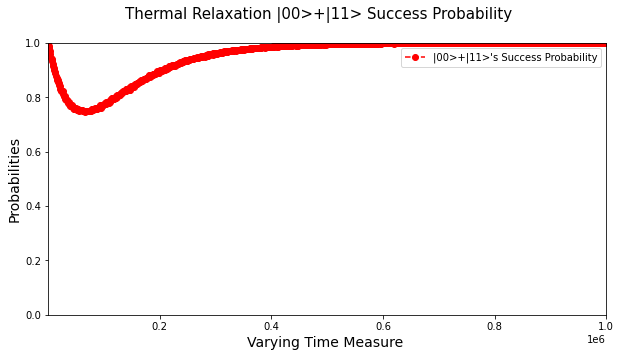

<Figure size 576x360 with 0 Axes>

In [26]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,label = "|00>+|11>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,'ro--',label = "|00>+|11>'s Success Probability")
ax.legend()

In [27]:
listofSuccess2=[]
for z in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    listofSuccess2.append(success)


In [28]:
from statistics import mean
a= listofSuccess2
print(*map(mean, zip(*a)))

0.94375 0.9372 0.9256000000000001 0.90835 0.90885 0.89645 0.886 0.87515 0.86825 0.8608 0.84605 0.8403499999999999 0.8297 0.8202499999999999 0.81085 0.7999 0.7942 0.78425 0.7746500000000001 0.76885 0.7635500000000001 0.74825 0.748 0.74095 0.72255 0.71665 0.7086 0.7078 0.69565 0.69575 0.68925 0.6777 0.6759000000000001 0.6627500000000001 0.65535 0.65145 0.64495 0.6377 0.6243 0.62005 0.6122 0.60975 0.59505 0.5964499999999999 0.5896 0.58505 0.57495 0.5719 0.56265 0.5591 0.5486500000000001 0.5394 0.54515 0.533 0.53305 0.52635 0.5147 0.51345 0.5033 0.504 0.4886 0.49215 0.49015 0.48025 0.4741 0.4681 0.46895 0.4612 0.459 0.44685 0.4473 0.4388 0.44295 0.4314 0.43074999999999997 0.4231 0.42469999999999997 0.41775 0.414 0.4053 0.40595 0.40245000000000003 0.39285000000000003 0.38815 0.38875 0.3812 0.3799 0.36985 0.3729 0.361 0.3573 0.35135 0.35955 0.3509 0.34405 0.3413 0.33735 0.3343 0.3257 0.3271 0.32655 0.321 0.32195 0.3096 0.30555 0.30045 0.30035 0.29975 0.29764999999999997 0.2982 0.2898 0.28105

In [29]:
# 20 Times Average 
b2=[0.94375,0.9372,0.9256000000000001,0.90835,0.90885,0.89645,0.886,0.87515,0.86825,0.8608,0.84605,0.8403499999999999,0.8297,0.8202499999999999,0.81085,0.7999,0.7942,0.78425,0.7746500000000001,0.76885,0.7635500000000001,0.74825,0.748,0.74095,0.72255,0.71665,0.7086,0.7078,0.69565,0.69575,0.68925,0.6777,0.6759000000000001,0.6627500000000001,0.65535,0.65145,0.64495,0.6377,0.6243,0.62005,0.6122,0.60975,0.59505,0.5964499999999999,0.5896,0.58505,0.57495,0.5719,0.56265,0.5591,0.5486500000000001,0.5394,0.54515,0.533,0.53305,0.52635,0.5147,0.51345,0.5033,0.504,0.4886,0.49215,0.49015,0.48025,0.4741,0.4681,0.46895,0.4612,0.459,0.44685,0.4473,0.4388,0.44295,0.4314,0.43074999999999997,0.4231,0.42469999999999997,0.41775,0.414,0.4053,0.40595,0.40245000000000003,0.39285000000000003,0.38815,0.38875,0.3812,0.3799,0.36985,0.3729,0.361,0.3573,0.35135,0.35955,0.3509,0.34405,0.3413,0.33735,0.3343,0.3257,0.3271,0.32655,0.321,0.32195,0.3096,0.30555,0.30045,0.30035,0.29975,0.29764999999999997,0.2982,0.2898,0.28105,0.28265,0.279,0.2796,0.27785,0.2701,0.2682,0.26405,0.26825,0.25485,0.2581,0.25355,0.25415,0.24605,0.24365,0.23855,0.24695,0.2348,0.2341,0.2403,0.2311,0.23245,0.22315,0.2251,0.2179,0.2186,0.2188,0.21365,0.2145,0.2091,0.20875,0.20285,0.20155,0.20405,0.19955,0.19285,0.2014,0.19735,0.19285,0.18605,0.18485000000000001,0.18165,0.1855,0.18325,0.17945,0.176,0.1777,0.17355,0.1749,0.1733,0.173,0.1651,0.165,0.1623,0.16335,0.1583,0.1532,0.15495,0.15395,0.15739999999999998,0.1539,0.14615,0.14905,0.14475,0.14835,0.148,0.146,0.13845,0.1382,0.1359,0.13215,0.1318,0.1346,0.13335,0.13345,0.1271,0.1256,0.1235,0.1208,0.1231,0.12335,0.124,0.1206,0.12085,0.12235,0.11185,0.11745,0.1197,0.11525,0.1108,0.10435,0.1106,0.10645,0.1053,0.1047,0.10255,0.1064,0.1009,0.1016,0.1001,0.0975,0.1,0.0969,0.0962,0.0945,0.09485,0.09635,0.0895,0.0893,0.09065,0.08765,0.08410000000000001,0.08805,0.08525,0.08645,0.0856,0.0832,0.082,0.08335,0.07615,0.07675,0.0822,0.0766,0.07894999999999999,0.0774,0.0764,0.07665,0.0735,0.072,0.07265,0.07065,0.07075000000000001,0.0704,0.06999999999999999,0.06945,0.07065,0.0667,0.0669,0.06505,0.06435,0.064,0.0644,0.0657,0.06335,0.06215,0.058499999999999996,0.0599,0.06085,0.057999999999999996,0.0564,0.055600000000000004,0.0587,0.0552,0.05865,0.05425,0.05505,0.053,0.0567,0.0519,0.052199999999999996,0.0525,0.05075,0.05075,0.05235,0.05105,0.0493,0.0489,0.045,0.047850000000000004,0.0486,0.04815,0.0472,0.04395,0.0424,0.04375,0.04215,0.0442,0.04375,0.04245,0.0437,0.0425,0.0408,0.039,0.03915,0.0415,0.038900000000000004,0.03885,0.03805,0.03825,0.0359,0.03605,0.0362,0.03665,0.0382,0.03635,0.03645,0.03495,0.03425,0.0343,0.03405,0.03385,0.0343,0.03325,0.0333,0.03215,0.03085,0.0298,0.03165,0.0305,0.03165,0.0287,0.029400000000000003,0.02755,0.03055,0.0285,0.0299,0.02885,0.0273,0.0262,0.0277,0.0275,0.02505,0.02645,0.02595,0.02705,0.0253,0.0273,0.02685,0.02605,0.02625,0.02265,0.022449999999999998,0.02335,0.0229,0.0259,0.0238,0.0218,0.023200000000000002,0.0219,0.02195,0.02315,0.021,0.0218,0.02015,0.02125,0.01875,0.0175,0.0197,0.019200000000000002,0.02095,0.01845,0.0182,0.019,0.01965,0.01775,0.01915,0.01865,0.01745,0.0181,0.0164,0.0169,0.018,0.0166,0.01665,0.017,0.0175,0.01795,0.01545,0.01675,0.0159,0.0158,0.01405,0.0147,0.014,0.01255,0.016,0.01475,0.01545,0.0151,0.0152,0.0135,0.01625,0.0132,0.0135,0.01375,0.0149,0.01295,0.01365,0.0141,0.012199999999999999,0.01355,0.0122,0.01365,0.0138,0.01345,0.01205,0.01165,0.01315,0.01175,0.01255,0.0122,0.0116,0.01135,0.0124,0.01095,0.01075,0.01075,0.00985,0.0111,0.00965,0.0103,0.0094,0.00905,0.0107,0.0108,0.009899999999999999,0.00925,0.0101,0.0085,0.00845,0.00925,0.0085,0.00945,0.0093,0.00985,0.00845,0.0089,0.009300000000000001,0.0076,0.0079,0.009,0.00865,0.0084,0.00785,0.00795,0.00845,0.0084,0.0084,0.0076,0.0077,0.008749999999999999,0.00655,0.0079,0.0067,0.00745,0.0066,0.00685,0.0075,0.0073999999999999995,0.00735,0.0070999999999999995,0.006500000000000001,0.0074,0.0073,0.00635,0.0063,0.0068,0.0064,0.0064,0.0059,0.00555,0.00575,0.0054,0.0052,0.005,0.0064,0.0056,0.00555,0.0063,0.0051,0.00565,0.0049,0.00485,0.0049,0.00525,0.0052,0.00525,0.00515,0.0053,0.00525,0.00485,0.0046500000000000005,0.00415,0.00375,0.0041,0.0045000000000000005,0.0047,0.0048000000000000004,0.0042,0.0046,0.0045,0.0043,0.00365,0.00415,0.0048000000000000004,0.0037,0.0042,0.00455,0.0038,0.0041,0.00385,0.004,0.0041,0.0038,0.004,0.0033,0.0036,0.004,0.004,0.0034000000000000002,0.00445,0.00355,0.00345,0.003,0.00425,0.00365,0.0037,0.0033,0.00365,0.0039000000000000003,0.0032500000000000003,0.004,0.00395,0.0027,0.00295,0.0034000000000000002,0.00305,0.00295,0.0025,0.00305,0.00295,0.0029000000000000002,0.0022,0.00285,0.0027,0.0023,0.00265,0.00205,0.00235,0.0027,0.0017000000000000001,0.00255,0.00255,0.00285,0.00215,0.0022,0.0028,0.0019,0.00215,0.0021,0.0029000000000000002,0.00285,0.0019,0.0022,0.0019500000000000001,0.00245,0.00115,0.0022,0.00205,0.0019,0.0019500000000000001,0.00235,0.0029000000000000002,0.00255,0.0016,0.00205,0.00165,0.00265,0.0026,0.0018,0.0019500000000000001,0.0019,0.00175,0.00175,0.00155,0.00185,0.00155,0.0014,0.0014,0.0018,0.0022,0.00165,0.0018,0.00135,0.00155,0.00125,0.0014500000000000001,0.0018,0.0018,0.0013,0.0015,0.00165,0.0013,0.0016,0.00175,0.00155,0.00115,0.00155,0.00165,0.0014500000000000001,0.0014500000000000001,0.00165,0.0008500000000000001,0.0017000000000000001,0.00125,0.0016,0.00115,0.00135,0.0013,0.0013,0.00135,0.001,0.0012000000000000001,0.00115,0.0015,0.0012000000000000001,0.0011,0.0012000000000000001,0.0013,0.00105,0.0013,0.00075,0.001,0.001,0.0014,0.00095,0.00125,0.0009,0.00105,0.0009,0.00115,0.0013,0.0008,0.00075,0.00115,0.00095,0.0009,0.0006000000000000001,0.00095,0.00115,0.00095,0.0008500000000000001,0.00065,0.00105,0.0008,0.00065,0.00075,0.00115,0.0012000000000000001,0.0009,0.00045,0.0011,0.0005,0.00105,0.0008500000000000001,0.0006000000000000001,0.00045,0.00055,0.00075,0.0006000000000000001,0.00055,0.0009,0.0006000000000000001,0.00055,0.00065,0.00035,0.0006000000000000001,0.00065,0.0007,0.0006000000000000001,0.00055,0.0008,0.00055,0.00065,0.00055,0.0008,0.00045,0.00025,0.00075,0.0006000000000000001,0.0005,0.00045,0.0005,0.0005,0.00030000000000000003,0.00045,0.00065,0.00045,0.00065,0.00055,0.0006000000000000001,0.0005,0.00065,0.00055,0.00030000000000000003,0.0005,0.0002,0.00035,0.00045,0.0004,0.00025,0.0006000000000000001,0.00035,0.0002,0.00055,0.0005,0.00035,0.0004,0.00035,0.00035,0.00045,0.00030000000000000003,0.0002,0.0005,0.0005,0.00035,0.00030000000000000003,0.00045,0.00075,0.0001,0.0006000000000000001,0.0005,0.0004,0.00035,0.00035,0.00035,0.0005,0.00030000000000000003,0.0001,0.00045,0.0002,0.00055,0.00045,0.00025,0.00030000000000000003,0.00035,0.00030000000000000003,0.00025,0.00035,0.0005,5e-05,0.00035,0.00035,0.0002,0.0002,0.00030000000000000003,0.00035,0.00025,0.00025,0.0004,0.0006000000000000001,0.00035,0.00035,0.00035,0.00035,0.00025,0.0004,0.0002,0.00015000000000000001,0.0001,0.00015000000000000001,0.00035,0.00035,0.00025,0.0001,0.00030000000000000003,0.00030000000000000003,0.00015000000000000001,0.0002,0.0001,0.00035,0.0002,5e-05,0.00015000000000000001,0.00030000000000000003,0.00025,0.00030000000000000003,0.00015000000000000001,5e-05,0.0001,0.00030000000000000003,0.0002,5e-05,0.00030000000000000003,0.0001,0.00030000000000000003,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.0001,0.00025,5e-05,5e-05,5e-05,5e-05,0.0001,0.00015000000000000001,0.00015000000000000001,0.0002,0.00015000000000000001,5e-05,0.0001,0.0,0.0002,0.0,0.00015000000000000001,0.00025,0.0001,0.0001,0.00025,0.0002,0.0001,0.00015000000000000001,0.0,0.0002,0.00015000000000000001,0.0001,0.00025,0.0001,0.0001,0.00015000000000000001,0.0001,0.0001,0.0001,0.0001,0.00015000000000000001,0.0001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.0,0.00015000000000000001,0.0001,0.00015000000000000001,5e-05,0.0001,0.0002,5e-05,5e-05,0.00025,5e-05,5e-05,5e-05,0.0002,0.0001,0.0001,5e-05,0.0001,0.0,0.0,0.00025,0.0001,0.00015000000000000001,5e-05,5e-05,5e-05,0.0001,0.00015000000000000001,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.00015000000000000001,5e-05,5e-05,5e-05,5e-05,5e-05,0.0,0.00015000000000000001,0.0,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.0001,0.0,0.00015000000000000001,0.0,0.0,0.0,5e-05,5e-05,0.0001,5e-05,5e-05,0.0001,0.0,0.0001,5e-05,0.0,5e-05,0.0001,5e-05,0.0001,5e-05,5e-05,5e-05,5e-05,0.0,5e-05,0.0,0.0001,0.0,0.0001,0.0001,5e-05,0.0,0.0,5e-05,0.0001,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0002,0.0,0.00015000000000000001,0.0,0.00015000000000000001,0.0,5e-05,0.0,0.00015000000000000001,0.0001,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0,0.00015000000000000001,0.0,0.0,5e-05,0.0,0.0,0.00015000000000000001,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0,5e-05,0.0001,0.0,5e-05,5e-05,5e-05,5e-05,0.0001,0.0,5e-05,0.0,5e-05,5e-05,0.0,0.0,0.0001,5e-05,5e-05,5e-05,0.0001,0.0,0.0,0.0,0.0,0.0001]

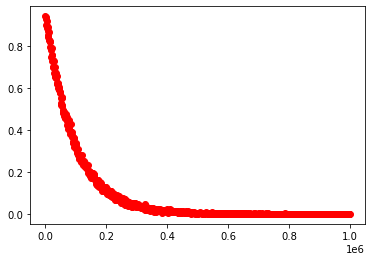

In [30]:
plt.plot(delay,success,'ro--')
plt.show()


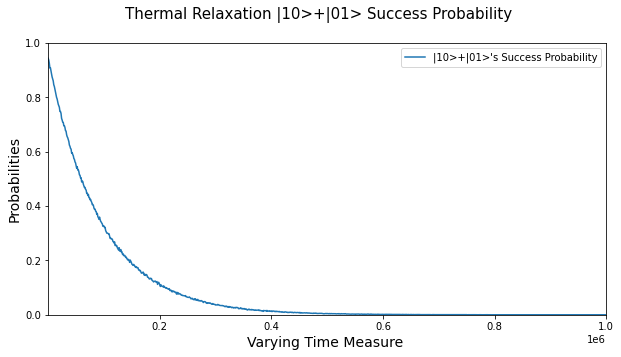

<Figure size 576x360 with 0 Axes>

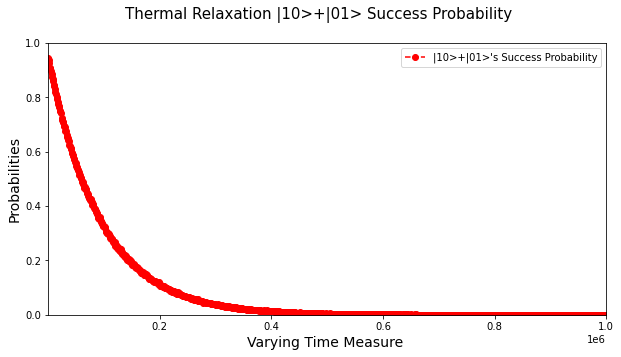

<Figure size 576x360 with 0 Axes>

In [31]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,label = "|10>+|01>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,'ro--',label = "|10>+|01>'s Success Probability")
ax.legend()
